In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")


In [12]:
b1 = pd.read_csv("api_data_aadhar_biometric_0_500000.csv")
b2 = pd.read_csv("api_data_aadhar_biometric_500000_1000000.csv")
b3 = pd.read_csv("api_data_aadhar_biometric_1000000_1500000.csv")
b4 = pd.read_csv("api_data_aadhar_biometric_1500000_1861108.csv")

bio_df = pd.concat([b1, b2, b3, b4], ignore_index=True)
bio_df.shape
bio_df.head()
bio_df.info()
bio_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


date            0
state           0
district        0
pincode         0
bio_age_5_17    0
bio_age_17_     0
dtype: int64

In [13]:
bio_df["date"] = pd.to_datetime(bio_df["date"], dayfirst=True, errors="coerce")
bio_df.fillna(0, inplace=True)

bio_df.describe()

,date,pincode,bio_age_5_17,bio_age_17_
count,1861108,1.861108e+06,1.861108e+06,1.861108e+06
mean,2025-10-22 22:32:04.288543232,5.217612e+05,1.839058e+01,1.909413e+01
min,2025-03-01 00:00:00,1.100010e+05,0.000000e+00,0.000000e+00
25%,2025-09-18 00:00:00,3.911750e+05,1.000000e+00,1.000000e+00
50%,2025-11-04 00:00:00,5.224010e+05,3.000000e+00,4.000000e+00
75%,2025-12-04 00:00:00,6.866362e+05,1.100000e+01,1.000000e+01
max,2025-12-29 00:00:00,8.554560e+05,8.002000e+03,7.625000e+03
std,NaN,1.981627e+05,8.370421e+01,8.806502e+01


In [15]:
bio_df["total_biometric"] = (
    bio_df["bio_age_5_17"] + bio_df["bio_age_17_"]
)


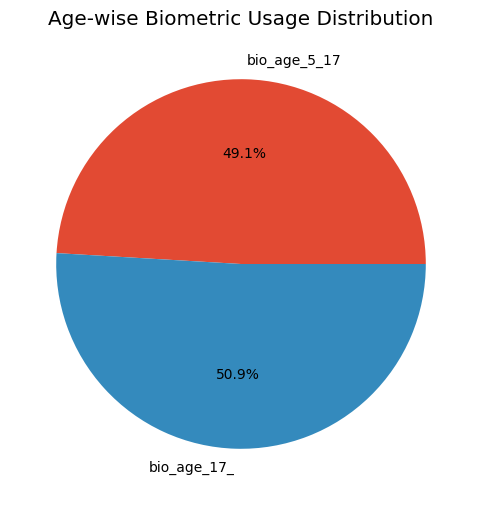

In [16]:
age_bio = bio_df[["bio_age_5_17", "bio_age_17_"]].sum()

age_bio.plot(kind="pie", autopct="%1.1f%%", figsize=(6,6))
plt.title("Age-wise Biometric Usage Distribution")
plt.ylabel("")
plt.show()


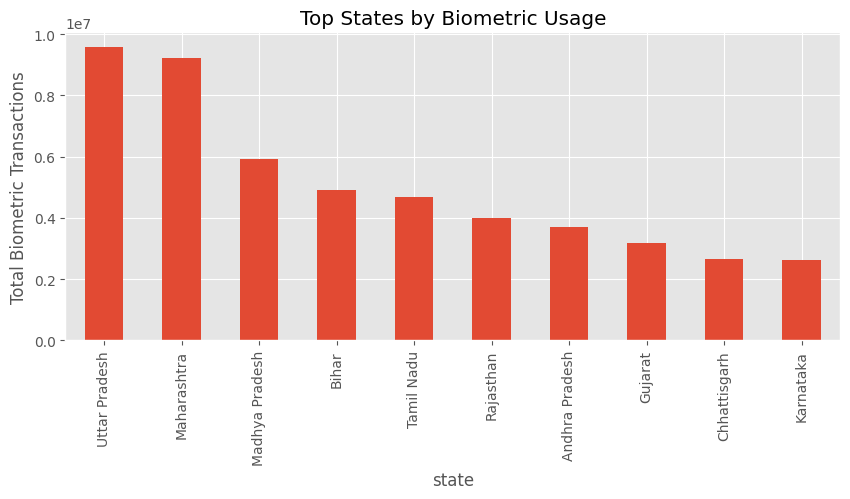

In [17]:
state_bio = (
    bio_df.groupby("state")["total_biometric"]
    .sum()
    .sort_values(ascending=False)
)

state_bio.head(10).plot(kind="bar", figsize=(10,4))
plt.title("Top States by Biometric Usage")
plt.ylabel("Total Biometric Transactions")
plt.show()


In [19]:
bio_df["adult_ratio"] = (
    bio_df["bio_age_17_"] / bio_df["total_biometric"]
).replace([np.inf, np.nan], 0)

adult_ratio_state = bio_df.groupby("state")["adult_ratio"].mean()

adult_ratio_state.sort_values(ascending=False).head()


state
Uttaranchal             1.000000
odisha                  1.000000
Westbengal              0.888889
Dadra & Nagar Haveli    0.866243
Pondicherry             0.807488
Name: adult_ratio, dtype: float64

In [20]:
Q1 = bio_df["total_biometric"].quantile(0.25)
Q3 = bio_df["total_biometric"].quantile(0.75)
IQR = Q3 - Q1

bio_df["anomaly"] = (
    bio_df["total_biometric"] > (Q3 + 1.5 * IQR)
)

bio_df[bio_df["anomaly"]].head()


,date,state,district,pincode,bio_age_5_17,bio_age_17_,total_biometric,adult_ratio,anomaly
0,2025-03-01,Haryana,Mahendragarh,123029,280,577,857,0.673279,True
1,2025-03-01,Bihar,Madhepura,852121,144,369,513,0.719298,True
2,2025-03-01,Jammu and Kashmir,Punch,185101,643,1091,1734,0.629181,True
3,2025-03-01,Bihar,Bhojpur,802158,256,980,1236,0.792880,True
4,2025-03-01,Tamil Nadu,Madurai,625514,271,815,1086,0.750460,True


In [21]:
district_bio = (
    bio_df.groupby("district")["total_biometric"]
    .sum()
    .sort_values(ascending=False)
)

district_bio.head(10)


district
Pune          605762
Nashik        576606
Thane         571273
Jalgaon       417384
Aurangabad    407803
Ahmedabad     405490
Mumbai        404359
Ahmadnagar    363561
Jaipur        355884
Nagpur        350923
Name: total_biometric, dtype: int64

In [22]:
district_bio.to_csv("biometric_district_load.csv")


In [24]:
bio_df["total_biometric"] = bio_df["bio_age_5_17"] + bio_df["bio_age_17_"]

bio_summary = bio_df.groupby("district").agg(
    total_biometric=("total_biometric", "sum")
).reset_index()

bio_summary.to_csv("bio_summary.csv", index=False)
